v0.1 (04/11/24)

## NeuroMotor Project

In [185]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

import scipy.signal as sig

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


path_all = '../RepositoryData'
plt.style.use('seaborn-v0_8-bright')


In [186]:
single_subject = path_all + '/SL01-T01'
sgl_subj_eeg = single_subject + '/eeg.txt'

In [187]:
# # check the path
# !ls -l $path_all

In [188]:
# the data we want from 2min to 17min with fs = 100Hz
t_walk_min = [2, 17]
t_first_5=[2,7]
t_first_ten=[2,12]
t_stand_min = [0, 2]
t_walkBCI_min = [17, 22]
t_stand_min_2 = [22, 24]

fs = 100

# Seperates into time periods for walking so that data scarcity can be simulated later
t_walk_data = {'t_start_walk': t_walk_min[0]*60*fs, 't_end_walk': t_walk_min[1]*60*fs}
t_walk_data5 = {'t_start_walk': t_first_5[0]*60*fs, 't_end_walk': t_first_5[1]*60*fs}
t_walk_data10 = {'t_start_walk': t_first_ten[0]*60*fs, 't_end_walk': t_first_ten[1]*60*fs}

# Data that probably wont be used but good to have handel for
t_stand_data = {'t_start_stand': t_stand_min[0]*60*fs, 't_end_stand': t_stand_min[1]*60*fs}
t_walkBCI_data = {'t_start_walkBCI': t_walkBCI_min[0]*60*fs, 't_end_walkBCI': t_walkBCI_min[1]*60*fs}
t_stand_data_2 = {'t_start_stand_2': t_stand_min_2[0]*60*fs, 't_end_stand_2': t_stand_min_2[1]*60*fs}

# all non-BCI data (probably wont be used)
t_useful_data = {'t_start_useful_1': t_stand_data['t_end_stand'], 't_end_useful_1': t_walk_data['t_start_walk'], 't_start_useful_2': t_stand_data_2['t_end_stand_2']}

In [189]:
# Load the data
eeg = pd.read_csv(sgl_subj_eeg, sep='\t', on_bad_lines='warn', skiprows=1, header=None)
eeg.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
time = eeg.iloc[:, 0]
eeg = eeg.iloc[:, 1:]
# print(eeg.head(10))
# print(time.head(10))
# take df to numpy array

# drops unwanted sections
eeg_walk=eeg.drop(range(t_walk_data['t_start_walk']))
eeg_walk=eeg_walk.drop(range(t_walk_data['t_end_walk']-1, eeg_walk.index[-1]))
eeg_walk = eeg_walk.to_numpy()
perform_drop=len(eeg_walk)==t_walk_data['t_end_walk']- t_walk_data['t_start_walk']

# checks to make sure desired rows were dropped
if perform_drop:
    print('Drop successful')
else:
    print('Length of array is: ' + str(len(eeg_walk)))
    print(' but is supposed to be '+ str(t_walk_data['t_end_walk']- t_walk_data['t_start_walk']))

# For general checking of data:
eeg = eeg.to_numpy()
time = time.to_numpy()
print(eeg.shape, time.shape)


Drop successful
(137242, 64) (137242,)


In [190]:
# print(time[0:100])

In [191]:
channel_1 = eeg[:, 1]
print(channel_1[0:10])
# print(time[1000:1010].shape, channel_1[1000:1010].shape)
print(time[0:10])

# print('Time interval: ', t_int_data)

# graph the first channel vs time with walking highlighted


[ 0.   0.   0.   0.   0.   0.  23.5 22.8 23.5 22.8]
[0.139 0.142 0.153 0.163 0.174 0.184 0.194 0.205 0.215 0.226]


In [192]:
# plot 64 channels in 8x8 grid, label the last 4 channels as EOG, and first 60 as EEG
def visualize_subject_eeg(eeg, time):
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            axs[i, j].plot(time, eeg[:, i * 8 + j])
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.show()

visualize_subject_eeg(eeg, time)

KeyboardInterrupt: 

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4


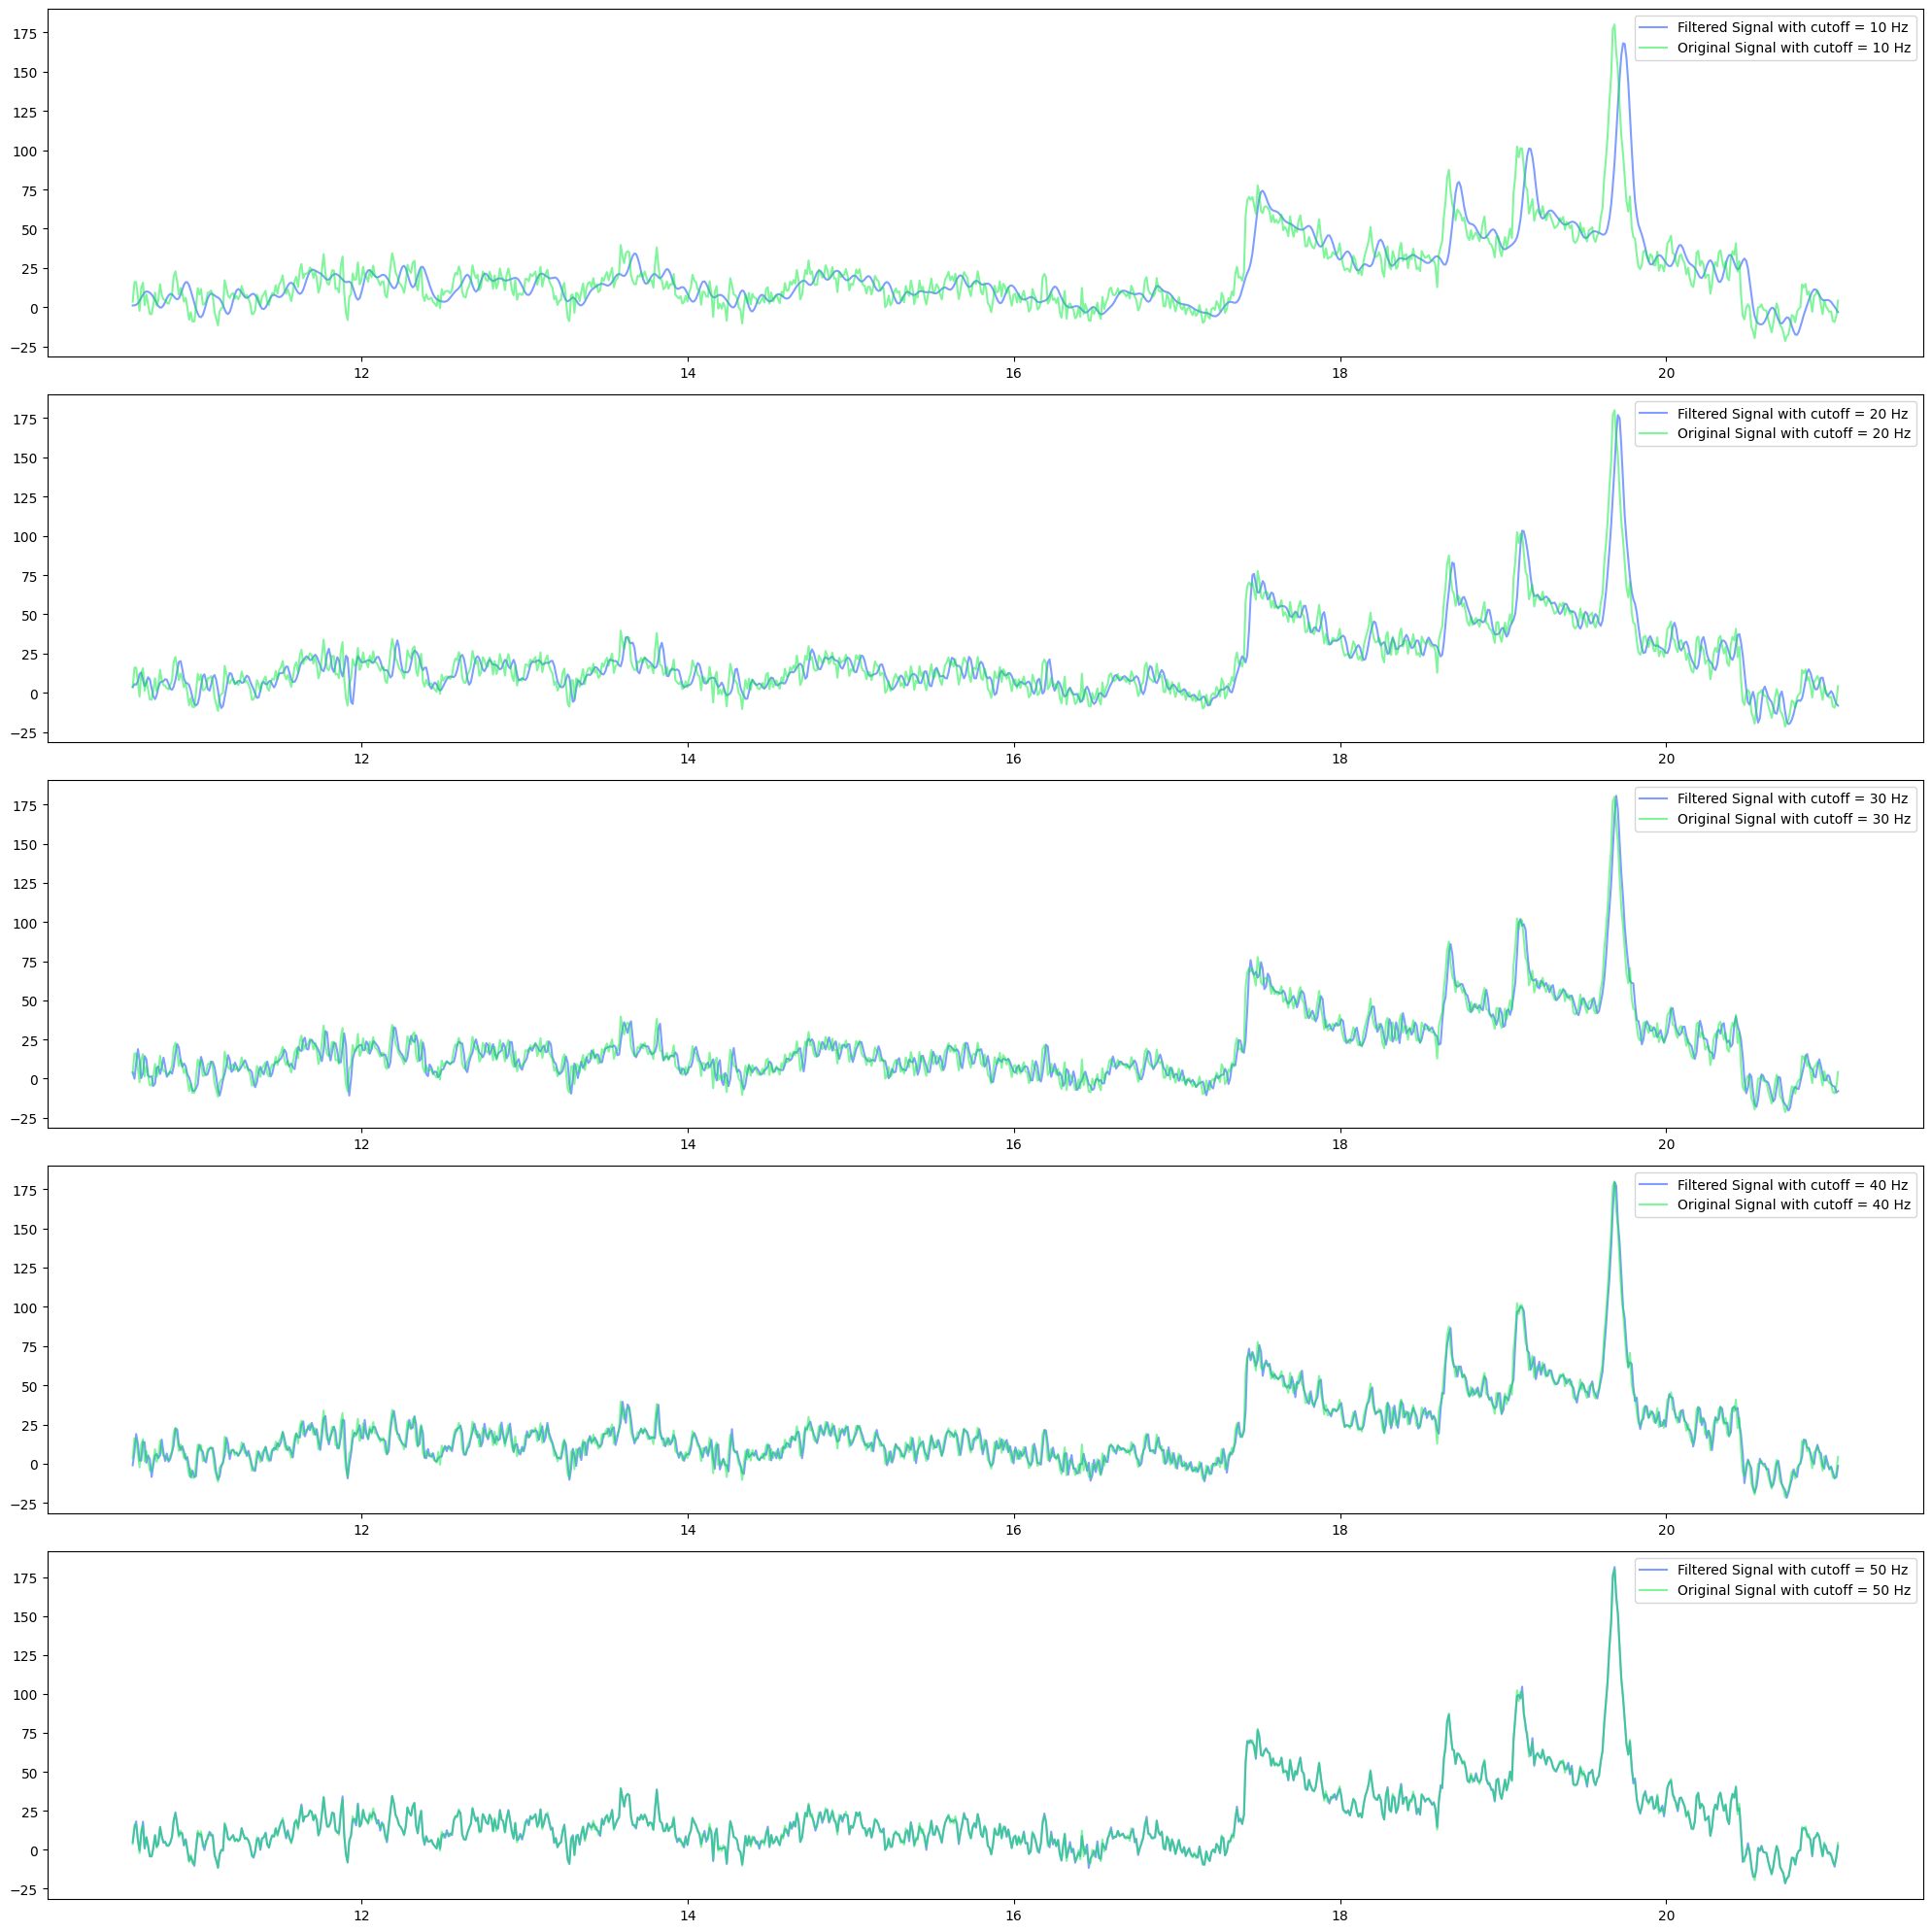

In [ ]:
def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

# y = lp(channel_1, 40)
figsize = (20, 20)

fig, axs = plt.subplots(5, 1, figsize=figsize)

for i in range (1, 6):
    index=i-1
    print(f"loop: {index}")
    y = eeg[:, 1]
    y_f = lp(y, i * 10) if i != 5 else lp(y, 49)
    axs[index].plot(time[1000:2000], y_f[1000:2000], alpha=.5, label=f"Filtered Signal with cutoff = {i*10} Hz")
    axs[index].plot(time[1000:2000], y[1000:2000], alpha=.5, label=f"Original Signal with cutoff = {i*10} Hz")
    axs[index].set_xlabel('Time (s)') if index == 5 else None
    axs[index].legend()

plt.tight_layout()
plt.show()

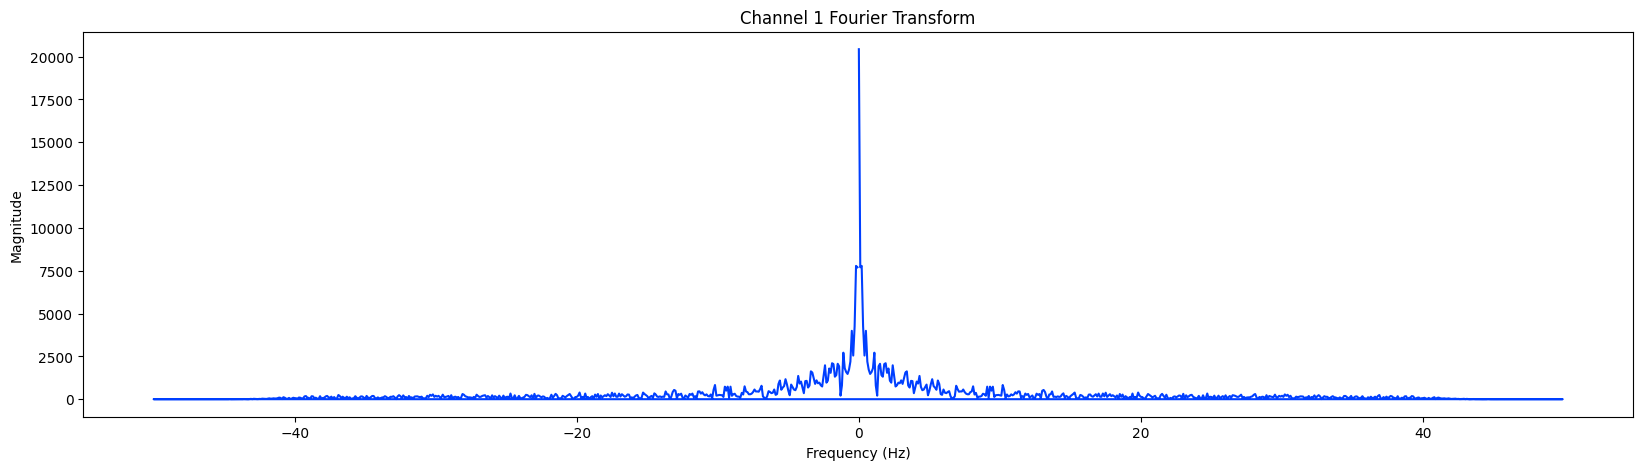

In [ ]:
# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)
    f = np.fft.fftfreq(n, 1/fs)
    y = np.fft.fft(data)
    return f, y

channel_1 = eeg[:, 1]

# filter the signal
channel_1_f = lp(channel_1, 40)
# get the fourier transform
f, y = fourier_transform(channel_1_f[1000:2000], 100)

plt.figure(figsize=(20, 5))
plt.plot(f, np.abs(y))
plt.title('Channel 1 Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

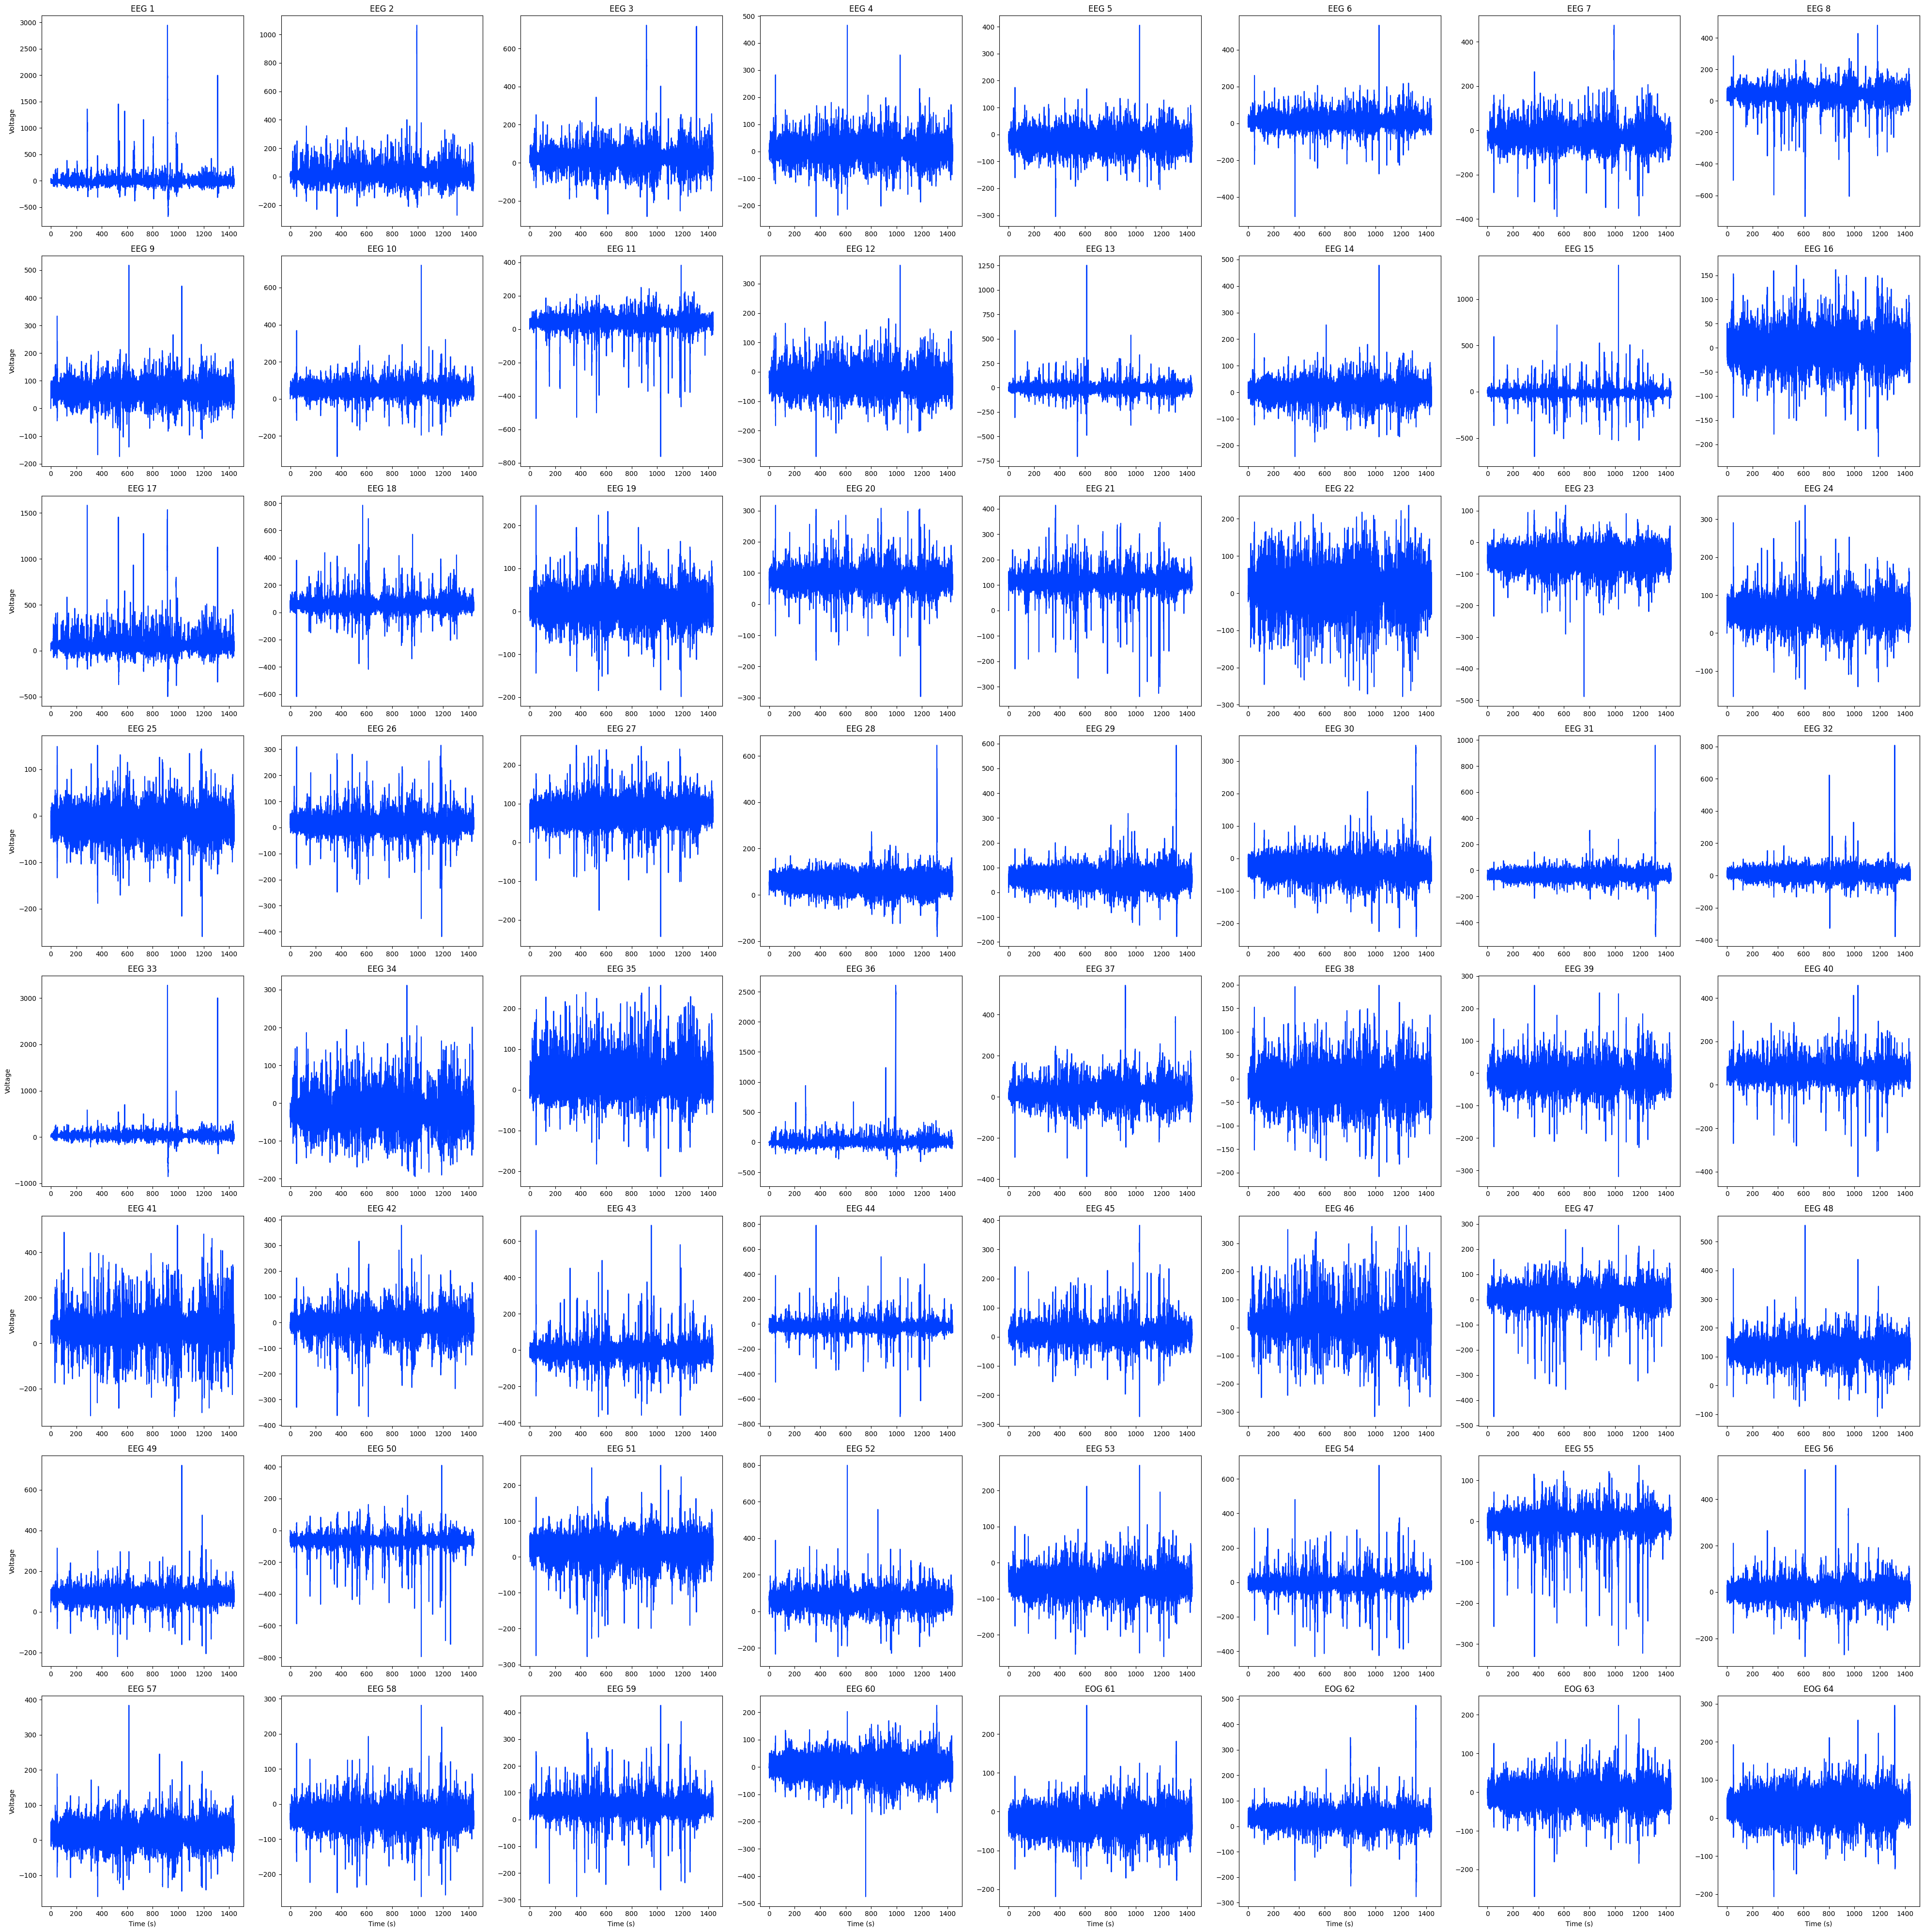

In [ ]:
def visualize_subject_eeg_flt(eeg, time):

    eeg_f = lp_50(eeg)
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            # axs[i, j].plot(time, eeg[:, i * 8 + j], label="o", alpha=.3)
            axs[i, j].plot(time, eeg_f[:, i * 8 + j], label="f", alpha=.3)
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.legend()
    plt.show()

visualize_subject_eeg(eeg, time)

Implementing PCA:

In [ ]:
# Start with normalizing the data with regard to independent variable
scaler = StandardScaler()
eeg_norm = scaler.fit_transform(eeg)

In [ ]:
# Loading dependent variable
sgl_joint_angl=single_subject+'/joints.txt'

# Remove the first 2 lines of the file using skiprows
j_angl = pd.read_csv(sgl_joint_angl, sep='\t', header=None ,names=list(range(14)), skiprows=2)

In [ ]:
# processing data
j_angl.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
j_time = j_angl.iloc[:, 0]
j_angl = j_angl.drop(0, axis=1)
j_angl = j_angl.drop(range(7,13), axis=1)
print(j_angl.head())


      1      2      3     4      5     6
0  1.44 -6.435 -3.375 -1.26  1.125  3.06
1  1.44 -6.435 -3.375 -1.26  1.125  3.06
2  1.44 -6.435 -3.375 -1.26  1.125  3.06
3  1.44 -6.435 -3.375 -1.26  1.125  3.06
4  1.44 -6.435 -3.375 -1.26  1.125  3.06


In [ ]:
# selects sections we want from joint data
j_walk=j_angl.drop(range(t_walk_data['t_start_walk']))
j_walk=j_walk.drop(range(t_walk_data['t_end_walk']-1, j_walk.index[-1]))
j_walk = j_walk.to_numpy()

In [ ]:
# Electrode labeling

# Loading electrode labels
sgl_ele_labels=single_subject+'/impedances-before.txt'

# Remove the first 2 lines of the file using skiprows
ele_imp = pd.read_csv(sgl_ele_labels, sep='\t', header=None , skiprows=20, names=list(range(5)))

ele_labels=ele_imp[1]
ele_labels=ele_labels.drop(0)


EOG_labels=[' TP9', 'TP10', ' FT9', 'FT10']
EOG_labels=ele_labels[ele_labels.iloc[:].isin(EOG_labels)]
EOG_indx=EOG_labels.index

# further processing
ele_labels.drop(ele_labels.tail(2).index,inplace=True)
ele_labels=list(ele_labels)
chan_type=['eeg']*64
for EoG in EOG_indx:
    chan_type[EoG]='eog'

In [ ]:
# If we could get this to work we could visualize the ICA
import mne 
import defusedxml.ElementTree

path_to_dig=single_subject+ '/digitizer.bvcf'
mne_info = mne.create_info(ch_names=ele_labels,
                    sfreq=fs,
                    ch_types=chan_type)

mne_raw = mne.io.RawArray(eeg_walk.transpose(), mne_info)

# Defining the electrodes architecture
try:
    montage = mne.channels.read_dig_captrak(path_to_dig)
except KeyError:
         pass

# montage.rename_channels(ele_labels)
mne_raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=64, n_times=90000
    Range : 0 ... 89999 =      0.000 ...   899.990 secs
Ready.


/tmp/ipykernel_15862/255460275.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_raw.set_montage(montage)


ValueError: DigMontage is only a subset of info. There are 57 channel positions not present in the DigMontage. The channels missing from the montage are:

[' Fp1', ' Fp2', '  F7', '  F3', '  Fz', '  F4', '  F8', ' FC5', ' FC1', ' FC2', ' FC6', '  T7', '  C3', '  Cz', '  C4', '  T8', ' TP9', ' CP1', ' CP2', ' CP6', '  P3', '  Pz', '  P4', '  P8', ' PO9', '  O1', '  Oz', '  O2', ' AF7', ' AF3', ' AF4', ' AF8', '  F5', '  F1', '  F2', '  F6', ' FT9', ' FC3', ' FC4', ' FT8', '  C1', '  C2', '  C6', ' TP7', ' CP3', ' CPz', ' CP4', ' TP8', '  P5', '  P1', '  P2', '  P6', ' PO7', ' PO3', ' POz', ' PO4', ' PO8'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

In [202]:
# PCA
pca = PCA(random_state=1)
pca.fit(eeg_walk)
eeg_walk_pca = pca.transform(eeg_walk)

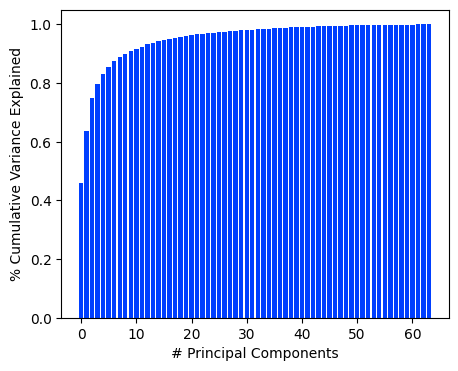

In [203]:
# Calculate cumulative explained variance across all PCs
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(range(64), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

In [216]:
# Select number of components based on graph
pca = PCA(n_components=8, random_state=1)
pca.fit(eeg_walk)
eeg_walk_pca = pca.transform(eeg_walk)
eeg_walk_rec = pca.inverse_transform(eeg_walk_pca)
for numb in range(8):
    print('The variance explained by component '+ str(numb)+ ' is '+str(round(100* pca.explained_variance_ratio_[numb]))+ '%')

The percentage explained by component 0 is 46%
The percentage explained by component 1 is 18%
The percentage explained by component 2 is 11%
The percentage explained by component 3 is 5%
The percentage explained by component 4 is 3%
The percentage explained by component 5 is 2%
The percentage explained by component 6 is 2%
The percentage explained by component 7 is 1%
